<a href="https://colab.research.google.com/github/JuNoe2020/DMC_class_2021/blob/main/Deep_Learning_code_review/%202flowers_classification_%EC%9C%A0%ED%98%84%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 결론

- 파라미터 갯수를 1000만 미만으로 줄이려면 Imagenet이나 mobilenet이 적합하다.
---
- 데이터증강을 통해 데이터를 무한대로 늘리고 성능을 높일 수 있을거라 생각했지만, 결과는 달랐다 일반적으로 데이터증강없이 원본데이터만으로 반복학습한 모델이 loss를 더 하락시킬 수 있었다.
---
- 정확한 모델 평가를 위해 test data를 카테고리별로 적어도 100개씩은 필요하지만 train data를 그만큼 줄이면 학습이 잘 안되는 경향이 있다.
---
- 더 정확한 validation loss 추이와 evaluation을 위해 근본적으로 더 많은 데이터만이 해답

## 라이브러리 불러오기

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Reshape
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import efficientnet

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import BatchNormalization


## 실시간 로스 체크 함수

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('acc'))
    self.val_acc.append(logs.get('val_acc'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.plot(self.x, self.acc, label="acc")
    plt.plot(self.x, self.val_acc, label="val_acc")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    print("acc = ", self.acc[-1], ", val_acc = ", self.val_acc[-1])

## 데이터 로딩함수

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
def load_file_names_and_category_names(path):
  
  file_names = []
  category_names = []

  dir_names = os.listdir(path)
      
  for dir_name in dir_names:
    file_names_in_a_dir = os.listdir(path+"/"+dir_name)

    for a_file_name in file_names_in_a_dir:
      full_file_name = path+"/"+dir_name+"/"+a_file_name
      file_names.append(full_file_name)
      category_names.append(dir_name)

  combined = list(zip(file_names, category_names))
  random.shuffle(combined)
  file_names, category_names = zip(*combined)

  return file_names, category_names


def load_image_files_into_numpy_array(file_names):
  file_count = len(file_names)    
  data = np.ndarray(shape=(file_count,224,224,3), dtype=np.float64)    
  for i in range(len(file_names)):
    image = load_img(file_names[i], target_size=(224, 224))
    image = img_to_array(image)
    data[i] = image
  return data


def load_custom_data(path, train_ratio=0.8):
  
  file_names, category_names = load_file_names_and_category_names(path)
  x = load_image_files_into_numpy_array(file_names)
  
  labels, y = np.unique(category_names, return_inverse=True)  

  s = int(x.shape[0]*train_ratio)
  train_x, test_x = x[:s], x[s:]
  train_y, test_y = y[:s], y[s:]
  
  return (train_x, train_y), (test_x, test_y), labels

# ##########전이학습##########

## train/validation/test 셋으로 따로 분류하여 학습

In [ ]:
#Callbacks 설정
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

### 데이터 불러오기

In [ ]:
# 8:2 비로 train/test data 분류
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

# efficientnet 전처리
train_x = efficientnet.preprocess_input(train_x)
test_x = efficientnet.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


### 모델

In [ ]:
# EfficientNetB2 설정
conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

# sequential모델 호출
model = models.Sequential()

# EfficientNetB2 전이학습
model.add(conv_layers)
model.add(layers.Flatten())

# DNN
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# 모델학습 환경설정
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 68992)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                2069790   
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                1

- 파라미터 갯수 9,839,591

In [ ]:
# 카테리고별 갯수 추출
unique, counts = np.unique(train_y, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 207, 1: 244}

In [ ]:
# class_weight 설정
class_weight ={0 : 1/uniq_cnt_dict[0], 1 : 1/uniq_cnt_dict[1] }
class_weight

{0: 0.004830917874396135, 1: 0.004098360655737705}

### 훈련 & 평가

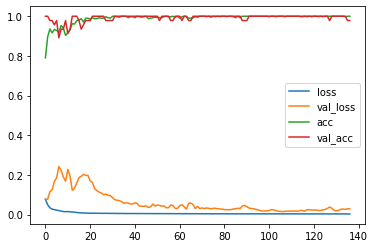

loss =  0.0029821719508618116 , val_loss =  0.028479887172579765
acc =  1.0 , val_acc =  0.97826087474823
Epoch 00137: early stopping
4/4 [==============================] - 1s 303ms/step - loss: 0.2029 - acc: 0.9469


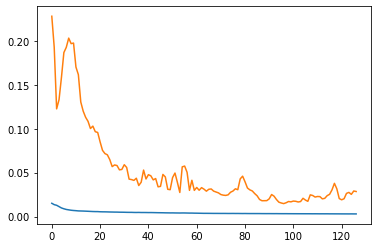

loss= 0.20291300117969513
acc= 0.9469026327133179


In [ ]:
# 훈련
hist = model.fit(
      train_x,
      train_y,
      validation_split=0.1, # 9:1 비로 train/validation data 분류
      shuffle=True, 
      batch_size=32,
      epochs=200,
      callbacks = callbacks,
      verbose = 1,
      class_weight = class_weight
)

# 평가
loss, acc = model.evaluate(
      test_x,
      test_y
)

# 번째 epochs 부터 그림그리기
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# 평가 accuracy 출력
print("loss=", loss)
print("acc=", acc)

## 모델평가없이 학습

### 데이터 불러오기

In [ ]:
# 8 : 2 비로 train/ validation data 분할
(train_x, train_y), (validation_x, validation_y), custom_labels = load_custom_data("data/2flowers_")

# efficientnet 전처리
train_x = efficientnet.preprocess_input(train_x)
test_x = efficientnet.preprocess_input(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


### 모델

In [ ]:
# EfficientNetB2 설정
conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

# sequential 모델 호출
model = models.Sequential()

# EfficientNetB2 전이학습
model.add(conv_layers)
model.add(layers.Flatten())

# DNN
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

# 학습방식 환경설정
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])

# 모델 요약
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_6 (Flatten)          (None, 68992)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)                2069790   
_________________________________________________________________
batch_normalization_12 (Batc (None, 30)                120       
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 30)                930       
_________________________________________________________________
batch_normalization_13 (Batc (None, 30)               

- 파마미터 갯수 : 9,839,591

In [ ]:
# 카테리고별 갯수 추출
unique, counts = np.unique(train_y, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 212, 1: 239}

In [ ]:
# class_weight 설정
class_weight ={0 : 1/uniq_cnt_dict[0], 1 : 1/uniq_cnt_dict[1] }
class_weight

{0: 0.0047169811320754715, 1: 0.0041841004184100415}

### 훈련

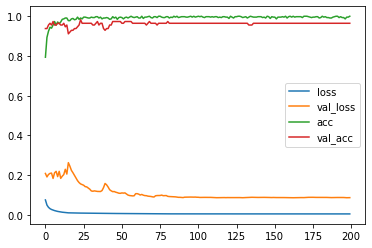

loss =  0.0052880491130054 , val_loss =  0.08715357631444931
acc =  1.0 , val_acc =  0.9646017551422119
4/4 [==============================] - 1s 121ms/step - loss: 0.0872 - acc: 0.9646


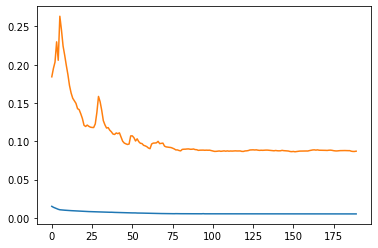

loss= 0.08715357631444931
acc= 0.9646017551422119


In [ ]:
# 훈련
hist = model.fit(
      train_x,
      train_y,
      validation_data=(validation_x, validation_y),
      shuffle=True, 
      batch_size=32,
      epochs=200,
      callbacks = callbacks,
      class_weight = class_weight
)

# validation data 평가지표로 사용
loss, acc = model.evaluate( 
      validation_x,
      validation_y
)

# 10번째 epochs부터 그림그리기
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# 마지막 validation accuracy 호출 
print("loss=", loss)
print("acc=", acc)

## 데이터증강을 통한 학습

### 데이터 증강

In [ ]:
# train 데이터 증강
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
      "data/2flowers/train",  # 8 : 2 비로 train, test data 폴더에 분류
      target_size=(224,224),  # 212 : 252 = daisy : dandelion
      batch_size=32,
      class_mode='sparse'
)

validation_data_generator = ImageDataGenerator(
      preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
      "data/2flowers/test",   # 50 : 50 = daisy : dandelion
      target_size=(224,224),
      batch_size=32,
      class_mode='sparse')

Found 464 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### 모델

In [ ]:
# MobileNetV2 설정
conv_layers = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

# sequential 모델 호출
model = models.Sequential()

# MobileNetV2 전이학습
model.add(conv_layers)
model.add(layers.Flatten())

# DNN
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# 학습방식 환경설정
model.compile(loss='sparse_categorical_crossentropy', optimizer='adamax', metrics=['acc'])

# 모델 요약
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6272100   
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

- 파라미터 갯수 8,541,186

In [ ]:
# class_weight 설정
# 212 : 252 = daisy : dandelion
class_weight ={0 : 1/212, 1 : 1/252 }
class_weight

{0: 0.0047169811320754715, 1: 0.003968253968253968}

### 훈련

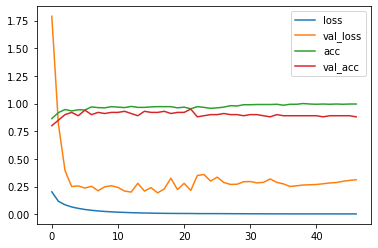

loss =  0.0030836323276162148 , val_loss =  0.311338871717453
acc =  0.9956896305084229 , val_acc =  0.8799999952316284
Epoch 00047: early stopping
3/3 [==============================] - 0s 114ms/step - loss: 0.3113 - acc: 0.8800
loss= 0.311338871717453
acc= 0.8799999952316284


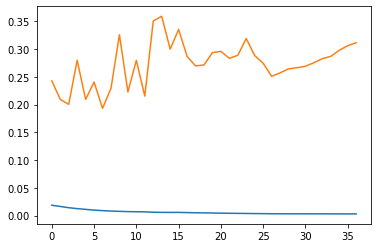

In [ ]:
# 훈련
hist = model.fit(
      train_data_generator,
      validation_data=validation_data_generator,
      steps_per_epoch=train_data_generator.samples/32,  
      shuffle=True, 
      epochs=200,
      callbacks = callbacks,
      class_weight=class_weight
)

# validation data 평가지표로 사용
loss, acc = model.evaluate(       # validation_data의 마지막 결과값 전달
      validation_data_generator,
      steps=validation_data_generator.samples/32
)

# 10번째 epochs부터 그림그리기
print("loss=", loss)
print("acc=", acc)

# 마지막 validation accuracy 호출 
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# #########Vanila CNN#########

## train/validation/test 셋으로 따로 분류하여 학습

### 데이터 로딩

In [ ]:
# cullbacks 설정
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [ ]:
# 8:2 비로 train/test data 분류
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("data/2flowers_")

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


### 모델

In [ ]:
# sequential 모델 호출
model = keras.Sequential()

# Vanila CNN
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3, 3), strides = (1, 1), padding='same'))    # 224 x 224 x 32
model.add(MaxPooling2D((2, 2)))   
model.add(Conv2D(64, (3, 3), strides = (1, 1), padding='same'))    # 112 x 112 x 64
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), strides = (1, 1), padding='same'))   #  56 x 56 x 128
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), strides = (1, 1), padding='same'))   #  28 x 28 x 256
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), strides = (1, 1), padding='same'))   #  14 x 14 x 512
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1024, (3, 3), strides = (1, 1), padding='same'))  #   7 x 7 x 1024
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())            

# DNN
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# 학습방식 환경설정
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 모델 요약
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)      

- 파라미터 갯수 : 7,220,994

In [ ]:
# 카테리고별 갯수 추출
unique, counts = np.unique(train_y, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 214, 1: 237}

In [ ]:
# class_weight 설정
class_weight ={0 : 1/uniq_cnt_dict[0], 1 : 1/uniq_cnt_dict[1] }
class_weight

{0: 0.004672897196261682, 1: 0.004219409282700422}

### 훈련 & 평가

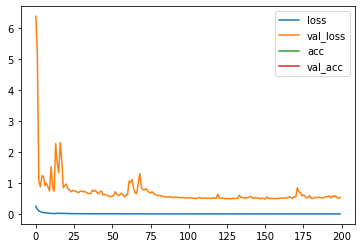

loss =  0.0036591680254787207 , val_loss =  0.5367333889007568
acc =  None , val_acc =  None
4/4 [==============================] - 0s 114ms/step - loss: 0.4337 - accuracy: 0.7876


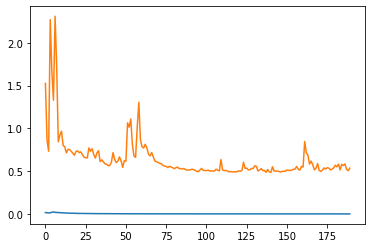

loss= 0.4337170422077179
acc= 0.7876105904579163


In [ ]:
# 훈련
hist = model.fit(
      train_x,
      train_y,
      validation_split=0.1, # 9:1 비로 train/validation data 분류
      shuffle=True, 
      batch_size=32,
      epochs=200,
      callbacks = callbacks,
      verbose = 1,
      class_weight = class_weight
)

# 평가
loss, acc = model.evaluate(
      test_x,
      test_y
)

# 10번째 epochs부터 그림그리기
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# 평가 accuracy 출력
print("loss=", loss)
print("acc=", acc)

## 모델평가없이 학습

### 데이터 로딩

In [ ]:
# train/validation data 8:2 분할
(train_x, train_y), (validation_x, validation_y), custom_labels = load_custom_data("data/2flowers_")

print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)
print(custom_labels)  

(451, 224, 224, 3)
(451,)
(113, 224, 224, 3)
(113,)
['daisy' 'dandelion']


### 모델

In [ ]:
# sequential 모델 호출
model = keras.Sequential()

# Vanila CNN
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3, 3), strides = (1, 1), padding='same'))    # 224 x 224 x 32
model.add(MaxPooling2D((2, 2)))   
model.add(Conv2D(64, (3, 3), strides = (1, 1), padding='same'))    # 112 x 112 x 64
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), strides = (1, 1), padding='same'))   #  56 x 56 x 128
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), strides = (1, 1), padding='same'))   #  28 x 28 x 256
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), strides = (1, 1), padding='same'))   #  14 x 14 x 512
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1024, (3, 3), strides = (1, 1), padding='same'))  #   7 x 7 x 1024
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())            

# DNN
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# 학습방식 환경설정
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 모델 요약
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 256)      

In [ ]:
# 카테리고별 갯수 추출
unique, counts = np.unique(train_y, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 206, 1: 245}

In [ ]:
# class_weight 설정
class_weight ={0 : 1/uniq_cnt_dict[0], 1 : 1/uniq_cnt_dict[1] }
class_weight

{0: 0.0048543689320388345, 1: 0.004081632653061225}

### 훈련

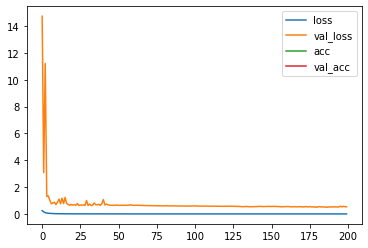

loss =  0.003019991097971797 , val_loss =  0.5394092798233032
acc =  None , val_acc =  None
4/4 [==============================] - 0s 34ms/step - loss: 0.5394 - accuracy: 0.7876


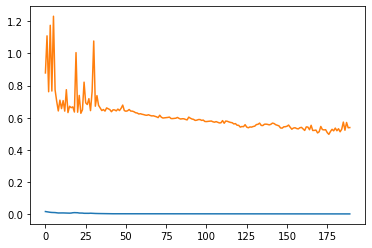

loss= 0.5394092798233032
acc= 0.7876105904579163


In [ ]:
# 훈련
hist = model.fit(
      train_x,
      train_y,
      validation_data=(validation_x, validation_y), 
      shuffle=True, 
      batch_size=32,
      epochs=200,
      callbacks = callbacks,
      class_weight = class_weight
)

# validation data 평가지표로 사용
loss, acc = model.evaluate(  
      validation_x,
      validation_y
)

# 10번째 epochs부터 그림그리기
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# 마지막 validation accuracy 호출 
print("loss=", loss)
print("acc=", acc)

## 데이터 증강을 통한 학습

### 데이터 증강

In [ ]:
# train data 로딩 & 증강
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
).flow_from_directory(
      "data/2flowers/train",  # 8 : 2 비로 train, test data 폴더에 분류
      target_size=(224,224),  # 212 : 252 = daisy : dandelion
      batch_size=32,
      class_mode='sparse'
)

# validation data 로딩
validation_data_generator = ImageDataGenerator(
).flow_from_directory(
      "data/2flowers/test",   # 50 : 50 = daisy : dandelion
      target_size=(224,224),
      batch_size=32,
      class_mode='sparse'
)

Found 464 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### 모델

In [ ]:
# seuqntial 모델 호출
model = keras.Sequential()

# Vanila CNN
model.add(Input((224,224,3)))
model.add(Conv2D(32, (3, 3), strides = (1, 1), padding='same'))    # 224 x 224 x 32
model.add(MaxPooling2D((2, 2)))   
model.add(Conv2D(64, (3, 3), strides = (1, 1), padding='same'))    # 112 x 112 x 64
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), strides = (1, 1), padding='same'))   #  56 x 56 x 128
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), strides = (1, 1), padding='same'))   #  28 x 28 x 256
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), strides = (1, 1), padding='same'))   #  14 x 14 x 512
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1024, (3, 3), strides = (1, 1), padding='same'))  #   7 x 7 x 1024
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())            

# DNN
model.add(Dense(200, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# 학습방식 환경설정
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 모델 요약
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)      

In [ ]:
# class_weight 설정
# 212 : 252 = daisy : dandelion
class_weight ={0 : 1/212, 1 : 1/252 }
class_weight

{0: 0.0047169811320754715, 1: 0.003968253968253968}

### 훈련 

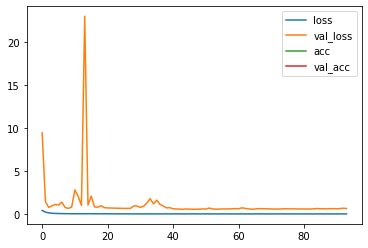

loss =  0.009775498881936073 , val_loss =  0.635054349899292
acc =  None , val_acc =  None
Epoch 00094: early stopping
3/3 [==============================] - 0s 113ms/step - loss: 0.6351 - accuracy: 0.7300


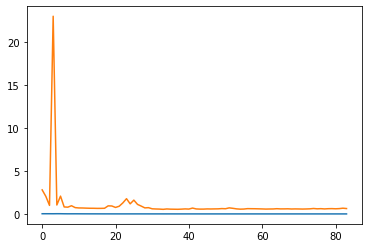

loss= 0.635054349899292
acc= 0.7300000190734863


In [ ]:
# 학습
hist = model.fit(
      train_data_generator,
      validation_data=validation_data_generator,
      steps_per_epoch=train_data_generator.samples/32,  
      shuffle=True, 
      epochs=200,
      callbacks = callbacks,
      class_weight=class_weight
)

# validation data 평가지표로 사용
loss, acc = model.evaluate(      
      validation_data_generator,
      steps=validation_data_generator.samples/32
)

# 10번째 epochs부터 그림그리기
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.show()

# 마지막 validation accuracy 호출 
print("loss=", loss)
print("acc=", acc)